# Exploration of AI data for the RWJF project

Here we explore the AI data for the RWJF project. This involves:

* Analysing World Report
  * Load
  * Map
  * Trend analysis
  * MeSH exploration
  
* Consider other sources such as CrunchBase or GitHub to illustrate the range of sources we are working with.




In [67]:
%matplotlib inline

import matplotlib.pyplot as plt

## World Reporter

In [2]:
my_files = os.listdir('../data/external/for_juan/')

dfs_list = []

for file in my_files:
    #print(file)
    #Problem file!
    if any(x in file for x in ['590000','180000','1170000','490000']):
        continue
    df = pd.read_json(f'../data/external/for_juan/{file}')
    dfs_list.append(df)

In [3]:
wr = pd.concat(dfs_list)

In [56]:
wr.reset_index(drop=True,inplace=True)

In [4]:
ai = pd.read_csv('../data/external/world_reporter/ai_projects')

### Initial exploration of world reporter

Protocol:

* What is in it?
  * Missing values
  * Types of entities
  * Entities relevant for the project (in this case health innovations)
  
* When does it cover?
  * How many years

* Where are these organisations?
  * Geography.

#### What is in it

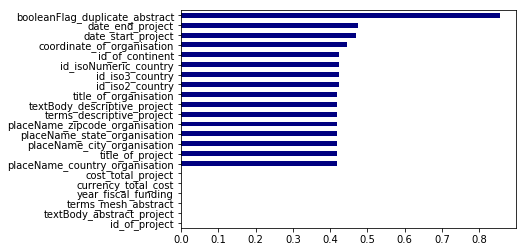

In [5]:
wr.apply(lambda x: x.isna().mean()).sort_values().plot.barh(color='navy')

Things to do:

* Why are there duplicates?
* What is the difference between project description and project abstract?


In [15]:
#On the duplicate abstracts

wr.booleanFlag_duplicate_abstract.sum()

219702.0

In [28]:
abstract_short = wr['textBody_abstract_project'].apply(lambda x: x[:1000] if type(x)==str else np.nan)

abstract_short.value_counts()[:5]

ABSTRACT NOT PROVIDED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      2149
No Abstract Provided                                                                                                                                                                                                                                                                                                                                                                                                    

A few missing values

In [31]:
print(sum(abstract_short.value_counts()>1))

print(sum(abstract_short.value_counts()==1))

371827
175807


There are 371827 beginnings of abstracts that appear more than once, and 157807 abstracts that appear *just once*. This means there are ~500K unique abstract texts. 

We will need to do some serious deduplication here.

Are any of the repeats because eg multiple organisations received a grant?

In [34]:
abstract_short.value_counts()[:10]

ABSTRACT NOT PROVIDED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2149
No Abstract Provided                                                                                                            

Some of the duplicates are repeating grants and awards involving multiple institutions. Let's check the one right above: 

Let's find abstracts missing

In [49]:
missing_abs = [any(x in text.lower() for x in ['abstract','no','not']) & (len(text)<100) for 
               text in wr['textBody_abstract_project']]

In [50]:
sum(missing_abs)

8294

Not a crazy number of missing abstracts beyond the NAs

#### Check one project where there are repeated abstracts

In [35]:
text_of_interest = "This contract is for a clinical center which is one of an estimated twenty-five centers that will conduct a large scale clinical trial on left ventricular dysfunction."

In [36]:
projects_with_text = wr.loc[[text_of_interest in text for text in wr.textBody_abstract_project]]


In [43]:
projects_with_text.head(n=20)[['title_of_organisation','terms_mesh_abstract']]

,title_of_organisation,terms_mesh_abstract
9712,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
113,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
122,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
131,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
140,TUFTS MEDICAL CENTER,"[Humans, Double-Blind Method, Analgesics, Pain..."
149,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
158,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
167,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
176,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."
185,NaN,"[Humans, Double-Blind Method, Analgesics, Pain..."


So this gives different organisations with the same MeSH terms. We should use the set of 'unique abstracts' for any querying 

#### Differences between text abstracts and paper abstracts

In [8]:
import random

for x in random.sample(range(len(wr)),5):
    
    print(wr.iloc[x]['textBody_descriptive_project'])
    
    print('\n')
    
    print(wr.iloc[x]['textBody_abstract_project'])
    
    print('\n')
    print('===')

nan


The central objective of this Project is to use miniprotein mimetic together with the emerging structure of the gp120/CD4 complex to design antagonists of the interaction of human cells with HIV-1, the human immunodeficiency virus responsible for AIDS. T-cell docking and entry by HIV-1, a major route of cell infection in AIDS, is driven by specific recognition of the T-cell surface protein CD4 by the HIV envelope protein gp120. The crystallographic structure of CD4 is known, and that of its complex with gp120 is close at hand. Structural components in both protein partners have been identified which are proposed to play key roles in CD4-gp120 recognition. The advancing high resolution structural understanding of the protein participants in virus-cell recognition together with the advancing technology of mimetics design now make it possible to combine structure determination, modeling and miniprotein engineering to obtain an advanced mechanistic understanding of the structural bas

The descriptions are an executive summary and the abstract is the scientific abstract

#### Organisations receiving grants

In [51]:
print(len(set(wr.title_of_organisation)))

wr.title_of_organisation.value_counts().head(n=10)

9481


JOHNS HOPKINS UNIVERSITY                  20654
UNIVERSITY OF PENNSYLVANIA                18350
UNIVERSITY OF WASHINGTON                  16955
UNIVERSITY OF PITTSBURGH AT PITTSBURGH    15127
UNIVERSITY OF CALIFORNIA LOS ANGELES      14796
WASHINGTON UNIVERSITY                     13677
YALE UNIVERSITY                           13658
STANFORD UNIVERSITY                       13558
UNIVERSITY OF CALIFORNIA SAN DIEGO        12705
DUKE UNIVERSITY                           12318
Name: title_of_organisation, dtype: int64

The organisations are mostly universities although we also find some companies

#### Relevant entities: do we find social/digital innovations?

To get a handle on this I will explore the MeSH terms. What are the top terms? Can we cluster them and if so do we find a digital/social cluster?


In [60]:
def flatten(a_list):
    '''
    flattens a list
    '''
    
    out = [x for el in a_list for x in el]
    
    return(out)


def term_distr(a_list):
    '''
    Counts elements in a flat list
    
    '''
    
    return(pd.Series(flatten(a_list)).value_counts())
    
    

In [61]:
mesh_distr = term_distr(wr.terms_mesh_abstract)

In [64]:
mesh_distr.head(n=10)

Humans           889279
Animals          638488
Goals            459083
Mice             278280
Female           189669
United States    144499
Male             122818
Rats             116165
Child            112867
DNA              108553
dtype: int64

In [65]:
len(mesh_distr)

53623

There are 53,263 MeSH terms

(array([9.5380e+03, 1.4441e+04, 1.0550e+04, 8.7380e+03, 6.2480e+03,
        2.9520e+03, 9.4900e+02, 1.8000e+02, 2.3000e+01, 4.0000e+00]),
 array([ 0.        ,  1.36981663,  2.73963326,  4.10944989,  5.47926652,
         6.84908315,  8.21889978,  9.58871641, 10.95853304, 12.32834967,
        13.6981663 ]),
 <a list of 10 Patch objects>)

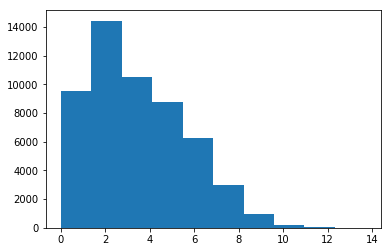

In [72]:
plt.hist(np.log(mesh_distr))

Most MeSH terms appear once.

#### How do we cluster them?

Options:


* Topic modelling
* community detection on topic co-occurrence network
* semantic clustering on w2v model


All these options might take a while. For now I'm going to take it very easy and simply look for digital and social terms and their synonyms

In [ ]:
#Lowercase
tokenised = [[x.lower() for x in tokens] for tokens in wr.terms_mesh_abstract]

In [197]:
wr['mesh_lower'] = tokenised

In [86]:
from gensim.models import Word2Vec

w2v = Word2Vec(tokenised)

In [178]:
def expanded_query(w2v,term,steps,thres=0.6,counts=True):
    '''
    Runs an expanded query on a w2v model. Steps is the number of steps it takes beyond the initial expansion.
    counts is whether it returns a count of term appearances, or a set.
    
    '''
    
    #Seed
    seed = [x[0] for x in w2v.wv.most_similar(term) if x[1]>thres]
    
    #return(seed)

    counter =0
        
    while counter<=steps:
        
        expand = [w2v.wv.most_similar(x) for x in set(seed)]
        
        new_set = list(set([x[0] for x in flatten(expand) if x[1]>thres]))
        
        seed = seed+new_set
        
        counter+=1
        
    #return(term_distr(seed))
    if counts==True:
        return(pd.Series(seed).value_counts())
    
    else:
        return(set(seed))

In [185]:
software_synonyms =expanded_query(w2v,'software',steps=2) 

software_synonyms.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


documentation                        4
machine learning                     4
computer systems                     4
information storage and retrieval    4
algorithms                           4
microcomputers                       4
internet                             4
cluster analysis                     4
automation                           4
computer communication networks      4
dtype: int64

In [187]:
online_synonyms = expanded_query(w2v,'internet',steps=2) 

online_synonyms.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


documentation                        4
referral and consultation            4
information services                 4
information storage and retrieval    4
computers, handheld                  4
marketing                            4
books                                4
information management               4
telecommunications                   4
resource allocation                  4
dtype: int64

In [184]:
social_env = expanded_query(w2v,'social environment',steps=2) 

social_env.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


personality                4
social class               4
anger                      4
health behavior            4
social support             4
self concept               4
marital status             4
peer group                 4
interpersonal relations    4
sexuality                  4
dtype: int64

In [181]:
peer = expanded_query(w2v,'health behavior',steps=2) 

peer.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


risk reduction behavior     4
health education            4
health status indicators    4
life style                  4
attitude                    4
social support              4
health promotion            4
health status               4
social class                4
exercise                    4
dtype: int64

In [188]:
health_pol = expanded_query(w2v,'health policy',steps=2) 

health_pol.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


health personnel                 4
quality of health care           4
health services accessibility    4
policy making                    4
evidence-based practice          4
insurance coverage               4
economics, medical               4
health services research         4
public policy                    4
health status                    3
dtype: int64

Lots of relevant keywords...but how many projects?

In [198]:
def extract_projects(df,term_list,appearances):
    '''
    Returns projects if relevant terms appear in it. Relevance is based on the number of times a term
    appeared in the expanded kw search
    
    '''
    
    terms = term_list.index[term_list>appearances]
    
    print(terms)
    
    projs = df.loc[[any(x in mesh for x in terms) for mesh in df.mesh_lower]]
    
    print(len(projs))
    
    return(projs)

In [199]:
digital_projects = extract_projects(wr,
                                    pd.concat([online_synonyms,software_synonyms]),
                                    3)

Index(['documentation', 'referral and consultation', 'information services',
       'information storage and retrieval', 'computers, handheld', 'marketing',
       'books', 'information management', 'telecommunications',
       'resource allocation', 'documentation', 'machine learning',
       'computer systems', 'information storage and retrieval', 'algorithms',
       'microcomputers', 'internet', 'cluster analysis', 'automation',
       'computer communication networks'],
      dtype='object')
73601


In [200]:
social_projects = extract_projects(wr,
                                   pd.concat([social_env,peer]),
                                    3)

Index(['personality', 'social class', 'anger', 'health behavior',
       'social support', 'self concept', 'marital status', 'peer group',
       'interpersonal relations', 'sexuality', 'risk reduction behavior',
       'health education', 'health status indicators', 'life style',
       'attitude', 'social support', 'health promotion', 'health status',
       'social class', 'exercise'],
      dtype='object')
69456


In [201]:
policy_projects = extract_projects(wr,
                                  health_pol,3)

Index(['health personnel', 'quality of health care',
       'health services accessibility', 'policy making',
       'evidence-based practice', 'insurance coverage', 'economics, medical',
       'health services research', 'public policy'],
      dtype='object')
21068


Non-insignificant numbers. There will be duplicates though!

In [209]:
def sample_projects(df,variable,sample_size,length_text):
    '''
    Sample some projects
    '''
    
    rel= random.sample(list(df[variable]),sample_size)
    
    for item in rel:
        
        print(item[:length_text])
        print('\n')
    

In [212]:
sample_projects(digital_projects,'textBody_abstract_project',5,500)

 DESCRIPTION (provided by applicant): Morbidity and mortality associated with vehicular crashes are a major public health concern, accompanied by great fiscal and emotional costs. While Type 1 Diabetes Mellitus (T1DM) drivers have over twice as many driving mishaps as non-diabetic drivers, this is accounted for by a subgroup. What is needed is a way to identify those diabetic drivers who are at high-risk, and interventions that can reduce this risk. We demonstrated that this high-risk subgroup d


DESCRIPTION (provided by applicant) A number of barriers, both real and perceived, tend to hinder the recruitment of patients, and by extension, minorities and poor people into clinical oncology trials at community centers. In order to initiate the opportunity to participate in clinical research at the community level, we have developed a collaborative regional network, The Radiation Oncology Community Outreach Group (ROCOG), based at UPMC McKeesport Hospital, that will build the infrastructu

In [213]:
sample_projects(social_projects,'textBody_abstract_project',5,500)

There are distinct gaps in our understanding of the link between obesity and/or fat distribution and increased disease risk in adolescent children. We propose a 5-year longitudinal study to examine the temporal relationships between changes in body fat, body fat pattern, insulin sensitivity, lipd profile, physical activity, and sex hormones during adolescent growth. We will use state-of-the-art techniques for measuring total body fat (4-compartment model), body fat pattern (dual energy X-ray abs


Our specific aim is to use and enrich existing patient self report and group level organizational data for patients receiving care in one of 58 managed care medical groups in California and the Pacific Northwest for the systematic analysis of the quality of medical are under varying features of managed care organizations. This collaborative effort between UCLA and the Pacific Business Group on Health (PBGH) will take place in an existing real world managed care laboratory whose infrastructure

In [214]:
sample_projects(health_pol,'textBody_abstract_project',5,500)

KeyError: 'textBody_abstract_project'